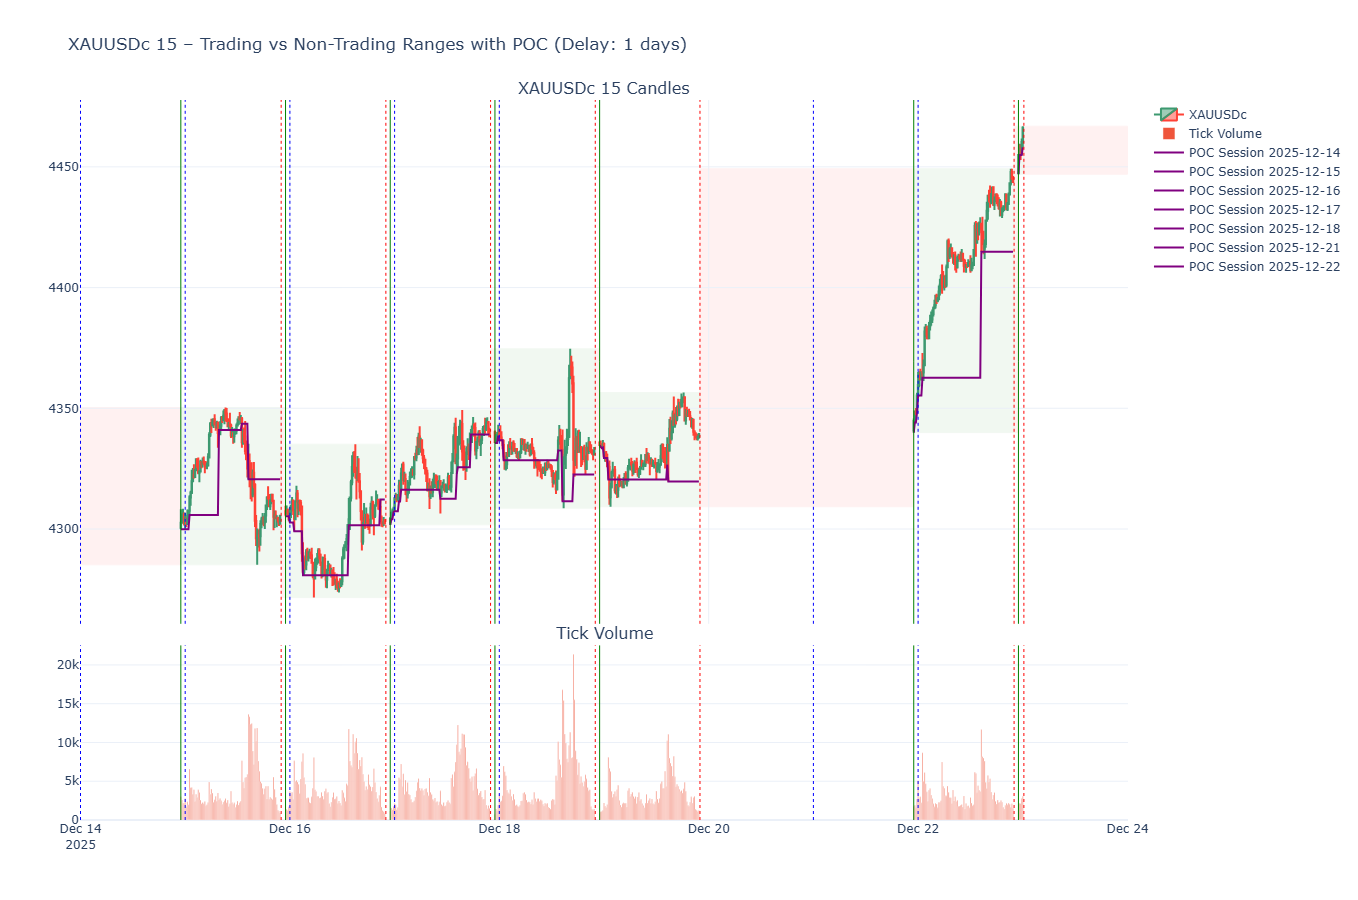

In [21]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M15   # can be any MT5 timeframe
lookback_days = 10              # number of days to look back
delay_days = 1                 # adjustable delay (days back from today)
utc_timezone = pytz.UTC

# -------------------------------------------------
# HELPER: Convert MT5 timeframe to timedelta
# -------------------------------------------------
def timeframe_to_timedelta(tf):
    mapping = {
        mt5.TIMEFRAME_M1: timedelta(minutes=1),
        mt5.TIMEFRAME_M2: timedelta(minutes=2),
        mt5.TIMEFRAME_M3: timedelta(minutes=3),
        mt5.TIMEFRAME_M4: timedelta(minutes=4),
        mt5.TIMEFRAME_M5: timedelta(minutes=5),
        mt5.TIMEFRAME_M6: timedelta(minutes=6),
        mt5.TIMEFRAME_M10: timedelta(minutes=10),
        mt5.TIMEFRAME_M12: timedelta(minutes=12),
        mt5.TIMEFRAME_M15: timedelta(minutes=15),
        mt5.TIMEFRAME_M20: timedelta(minutes=20),
        mt5.TIMEFRAME_M30: timedelta(minutes=30),
        mt5.TIMEFRAME_H1: timedelta(hours=1),
        mt5.TIMEFRAME_H2: timedelta(hours=2),
        mt5.TIMEFRAME_H3: timedelta(hours=3),
        mt5.TIMEFRAME_H4: timedelta(hours=4),
        mt5.TIMEFRAME_H6: timedelta(hours=6),
        mt5.TIMEFRAME_H8: timedelta(hours=8),
        mt5.TIMEFRAME_H12: timedelta(hours=12),
        mt5.TIMEFRAME_D1: timedelta(days=1),
        mt5.TIMEFRAME_W1: timedelta(weeks=1),
        mt5.TIMEFRAME_MN1: timedelta(days=30),
    }
    return mapping.get(tf, timedelta(hours=1))  # default 1 hour

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA RANGE WITH DELAY
# -------------------------------------------------
utc_now = datetime.now(utc_timezone).replace(hour=0, minute=0, second=0, microsecond=0)
utc_now -= timedelta(days=delay_days)  # shift to yesterday or adjustable delay
utc_from = utc_now - timedelta(days=lookback_days)  # lookback window

rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)
df.sort_index(inplace=True)

# -------------------------------------------------
# DETECT TRADING SESSIONS
# -------------------------------------------------
candle_delta = timeframe_to_timedelta(timeframe)
df["gap"] = df.index.to_series().diff() > candle_delta
df["session"] = df["gap"].cumsum()

trading_sessions = []
non_trading_gaps = []

# Trading sessions: consecutive candles
for session_id, group in df.groupby("session"):
    trading_sessions.append({
        "x0": group.index.min(),
        "x1": group.index.max() + candle_delta,  # include last candle
        "y0": group["low"].min(),
        "y1": group["high"].max(),
        "df": group  # store session dataframe for POC calculation
    })

# Non-trading gaps between sessions
for i in range(len(trading_sessions) - 1):
    gap_start = trading_sessions[i]["x1"]
    gap_end = trading_sessions[i + 1]["x0"]
    if gap_start < gap_end:
        non_trading_gaps.append({
            "x0": gap_start,
            "x1": gap_end,
            "y0": min(trading_sessions[i]["y0"], trading_sessions[i+1]["y0"]),
            "y1": max(trading_sessions[i]["y1"], trading_sessions[i+1]["y1"])
        })

# Gaps before first session and after last session
first_candle = trading_sessions[0]
last_candle = trading_sessions[-1]
day_start = datetime.combine(first_candle["x0"].date(), datetime.min.time()).replace(tzinfo=utc_timezone)
day_end = datetime.combine(last_candle["x1"].date(), datetime.max.time()).replace(tzinfo=utc_timezone)

if day_start < first_candle["x0"]:
    non_trading_gaps.insert(0, {"x0": day_start, "x1": first_candle["x0"], "y0": first_candle["y0"], "y1": first_candle["y1"]})
if last_candle["x1"] < day_end:
    non_trading_gaps.append({"x0": last_candle["x1"], "x1": day_end, "y0": last_candle["y0"], "y1": last_candle["y1"]})

# -------------------------------------------------
# PLOTLY FIGURE
# -------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.75, 0.25],
    subplot_titles=(f"{symbol} {timeframe} Candles", "Tick Volume")
)

# Candlesticks
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name=symbol
    ),
    row=1,
    col=1
)

# Tick volume
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# Trading sessions (green rectangles)
for session in trading_sessions:
    fig.add_shape(
        type="rect",
        x0=session["x0"],
        x1=session["x1"],
        y0=session["y0"],
        y1=session["y1"],
        line=dict(color="green", width=1),
        fillcolor="green",
        opacity=0.05,
        layer="below"
    )

# Non-trading gaps (red rectangles)
for gap in non_trading_gaps:
    fig.add_shape(
        type="rect",
        x0=gap["x0"],
        x1=gap["x1"],
        y0=gap["y0"],
        y1=gap["y1"],
        line=dict(color="red", width=1),
        fillcolor="red",
        opacity=0.05,
        layer="below"
    )

# -------------------------------------------------
# VERTICAL LINES: session start, session end, 0:00 UTC (all panes)
# -------------------------------------------------
for session in trading_sessions:
    session_start = session["x0"]
    session_end = session["x1"]
    day_midnight = datetime.combine(session_start.date(), datetime.min.time()).replace(tzinfo=utc_timezone)

    fig.add_vline(x=day_midnight, line=dict(color="blue", width=1, dash="dot"), row="all", col=1)
    fig.add_vline(x=session_start, line=dict(color="green", width=1, dash="solid"), row="all", col=1)
    fig.add_vline(x=session_end, line=dict(color="red", width=1, dash="dot"), row="all", col=1)

# -------------------------------------------------
# DEVELOPING POC (Point of Control)
# -------------------------------------------------
for session in trading_sessions:
    sess_df = session["df"]
    poc_prices = []  # track developing POC
    poc_times = []

    # Compute cumulative tick volume per price level
    cumulative_volume = {}
    for idx, row in sess_df.iterrows():
        # approximate POC using candle high-low with tick volume distributed evenly
        price_levels = np.linspace(row["low"], row["high"], num=10)  # 10 levels per candle
        vol_per_level = row["tick_volume"] / len(price_levels)
        for price in price_levels:
            cumulative_volume[price] = cumulative_volume.get(price, 0) + vol_per_level
        # find current POC
        poc_price = max(cumulative_volume, key=cumulative_volume.get)
        poc_prices.append(poc_price)
        poc_times.append(idx)

    # Plot developing POC as line
    fig.add_trace(
        go.Scatter(
            x=poc_times,
            y=poc_prices,
            mode="lines",
            line=dict(color="purple", width=2),
            name=f"POC Session {session['x0'].date()}"
        ),
        row=1,
        col=1
    )

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title=f"{symbol} {timeframe} – Trading vs Non-Trading Ranges with POC (Delay: {delay_days} days)",
    height=900,
    xaxis_rangeslider_visible=False,
    showlegend=True,
    template="plotly_white"
)

fig.show()


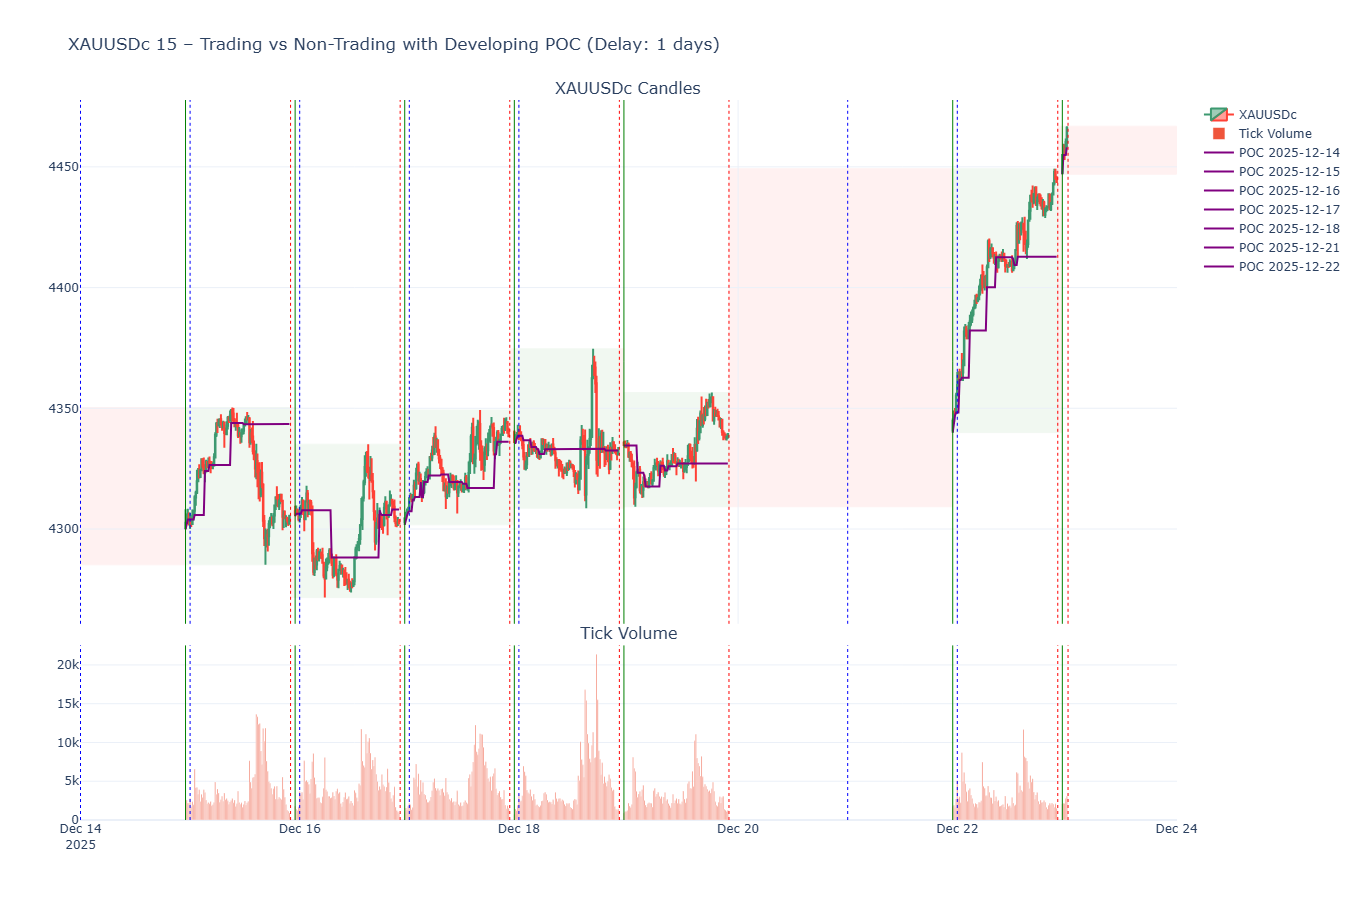

In [3]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M15   # any MT5 timeframe
lookback_days = 10              # number of days to look back
delay_days = 1                  # adjustable delay (days back from today)
utc_timezone = pytz.UTC

# -------------------------------------------------
# HELPER: Convert MT5 timeframe to timedelta
# -------------------------------------------------
def timeframe_to_timedelta(tf):
    mapping = {
        mt5.TIMEFRAME_M1: timedelta(minutes=1),
        mt5.TIMEFRAME_M2: timedelta(minutes=2),
        mt5.TIMEFRAME_M3: timedelta(minutes=3),
        mt5.TIMEFRAME_M4: timedelta(minutes=4),
        mt5.TIMEFRAME_M5: timedelta(minutes=5),
        mt5.TIMEFRAME_M6: timedelta(minutes=6),
        mt5.TIMEFRAME_M10: timedelta(minutes=10),
        mt5.TIMEFRAME_M12: timedelta(minutes=12),
        mt5.TIMEFRAME_M15: timedelta(minutes=15),
        mt5.TIMEFRAME_M20: timedelta(minutes=20),
        mt5.TIMEFRAME_M30: timedelta(minutes=30),
        mt5.TIMEFRAME_H1: timedelta(hours=1),
        mt5.TIMEFRAME_H2: timedelta(hours=2),
        mt5.TIMEFRAME_H3: timedelta(hours=3),
        mt5.TIMEFRAME_H4: timedelta(hours=4),
        mt5.TIMEFRAME_H6: timedelta(hours=6),
        mt5.TIMEFRAME_H8: timedelta(hours=8),
        mt5.TIMEFRAME_H12: timedelta(hours=12),
        mt5.TIMEFRAME_D1: timedelta(days=1),
        mt5.TIMEFRAME_W1: timedelta(weeks=1),
        mt5.TIMEFRAME_MN1: timedelta(days=30),
    }
    return mapping.get(tf, timedelta(hours=1))  # default 1 hour

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA RANGE WITH DELAY
# -------------------------------------------------
utc_now = datetime.now(utc_timezone).replace(hour=0, minute=0, second=0, microsecond=0)
utc_now -= timedelta(days=delay_days)  # shift by adjustable delay
utc_from = utc_now - timedelta(days=lookback_days)  # lookback window

rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)
df.sort_index(inplace=True)

# -------------------------------------------------
# DETECT TRADING SESSIONS
# -------------------------------------------------
candle_delta = timeframe_to_timedelta(timeframe)
df["gap"] = df.index.to_series().diff() > candle_delta
df["session"] = df["gap"].cumsum()

trading_sessions = []
non_trading_gaps = []

# Trading sessions: consecutive candles
for session_id, group in df.groupby("session"):
    trading_sessions.append({
        "x0": group.index.min(),
        "x1": group.index.max() + candle_delta,  # include last candle
        "y0": group["low"].min(),
        "y1": group["high"].max(),
        "df": group  # store session dataframe for POC calculation
    })

# Non-trading gaps between sessions
for i in range(len(trading_sessions) - 1):
    gap_start = trading_sessions[i]["x1"]
    gap_end = trading_sessions[i + 1]["x0"]
    if gap_start < gap_end:
        non_trading_gaps.append({
            "x0": gap_start,
            "x1": gap_end,
            "y0": min(trading_sessions[i]["y0"], trading_sessions[i+1]["y0"]),
            "y1": max(trading_sessions[i]["y1"], trading_sessions[i+1]["y1"])
        })

# Gaps before first session and after last session
first_candle = trading_sessions[0]
last_candle = trading_sessions[-1]
day_start = datetime.combine(first_candle["x0"].date(), datetime.min.time()).replace(tzinfo=utc_timezone)
day_end = datetime.combine(last_candle["x1"].date(), datetime.max.time()).replace(tzinfo=utc_timezone)

if day_start < first_candle["x0"]:
    non_trading_gaps.insert(0, {"x0": day_start, "x1": first_candle["x0"], "y0": first_candle["y0"], "y1": first_candle["y1"]})
if last_candle["x1"] < day_end:
    non_trading_gaps.append({"x0": last_candle["x1"], "x1": day_end, "y0": last_candle["y0"], "y1": last_candle["y1"]})

# -------------------------------------------------
# PLOTLY FIGURE
# -------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.75, 0.25],
    subplot_titles=(f"{symbol} Candles", "Tick Volume")
)

# Candlesticks
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name=symbol
    ),
    row=1,
    col=1
)

# Tick volume
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# Trading sessions (green rectangles)
for session in trading_sessions:
    fig.add_shape(
        type="rect",
        x0=session["x0"],
        x1=session["x1"],
        y0=session["y0"],
        y1=session["y1"],
        line=dict(color="green", width=1),
        fillcolor="green",
        opacity=0.05,
        layer="below"
    )

# Non-trading gaps (red rectangles)
for gap in non_trading_gaps:
    fig.add_shape(
        type="rect",
        x0=gap["x0"],
        x1=gap["x1"],
        y0=gap["y0"],
        y1=gap["y1"],
        line=dict(color="red", width=1),
        fillcolor="red",
        opacity=0.05,
        layer="below"
    )

# -------------------------------------------------
# VERTICAL LINES: session start, session end, 0:00 UTC (all panes)
# -------------------------------------------------
for session in trading_sessions:
    session_start = session["x0"]
    session_end = session["x1"]
    day_midnight = datetime.combine(session_start.date(), datetime.min.time()).replace(tzinfo=utc_timezone)

    fig.add_vline(x=day_midnight, line=dict(color="blue", width=1, dash="dot"), row="all", col=1)
    fig.add_vline(x=session_start, line=dict(color="green", width=1, dash="solid"), row="all", col=1)
    fig.add_vline(x=session_end, line=dict(color="red", width=1, dash="dot"), row="all", col=1)

# -------------------------------------------------
# DEVELOPING POC (Point of Control) WITH 0.25 PRICE INTERVAL
# -------------------------------------------------
for session in trading_sessions:
    sess_df = session["df"]
    poc_prices = []
    poc_times = []

    cumulative_volume = {}

    for idx, row in sess_df.iterrows():
        # Fine-grained price levels at 0.25 intervals
        price_levels = np.arange(row["low"], row["high"] + 0.01, 0.01)
        vol_per_level = row["tick_volume"] / len(price_levels)
        for price in price_levels:
            price = round(price, 2)  # avoid float precision issues
            cumulative_volume[price] = cumulative_volume.get(price, 0) + vol_per_level

        # Current POC (price with max cumulative volume)
        poc_price = max(cumulative_volume, key=cumulative_volume.get)
        poc_prices.append(poc_price)
        poc_times.append(idx)

    # Plot developing POC
    fig.add_trace(
        go.Scatter(
            x=poc_times,
            y=poc_prices,
            mode="lines",
            line=dict(color="purple", width=2),
            name=f"POC {session['x0'].date()}"
        ),
        row=1,
        col=1
    )

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title=f"{symbol} {timeframe} – Trading vs Non-Trading with Developing POC (Delay: {delay_days} days)",
    height=900,
    xaxis_rangeslider_visible=False,
    showlegend=True,
    template="plotly_white"
)

fig.show()


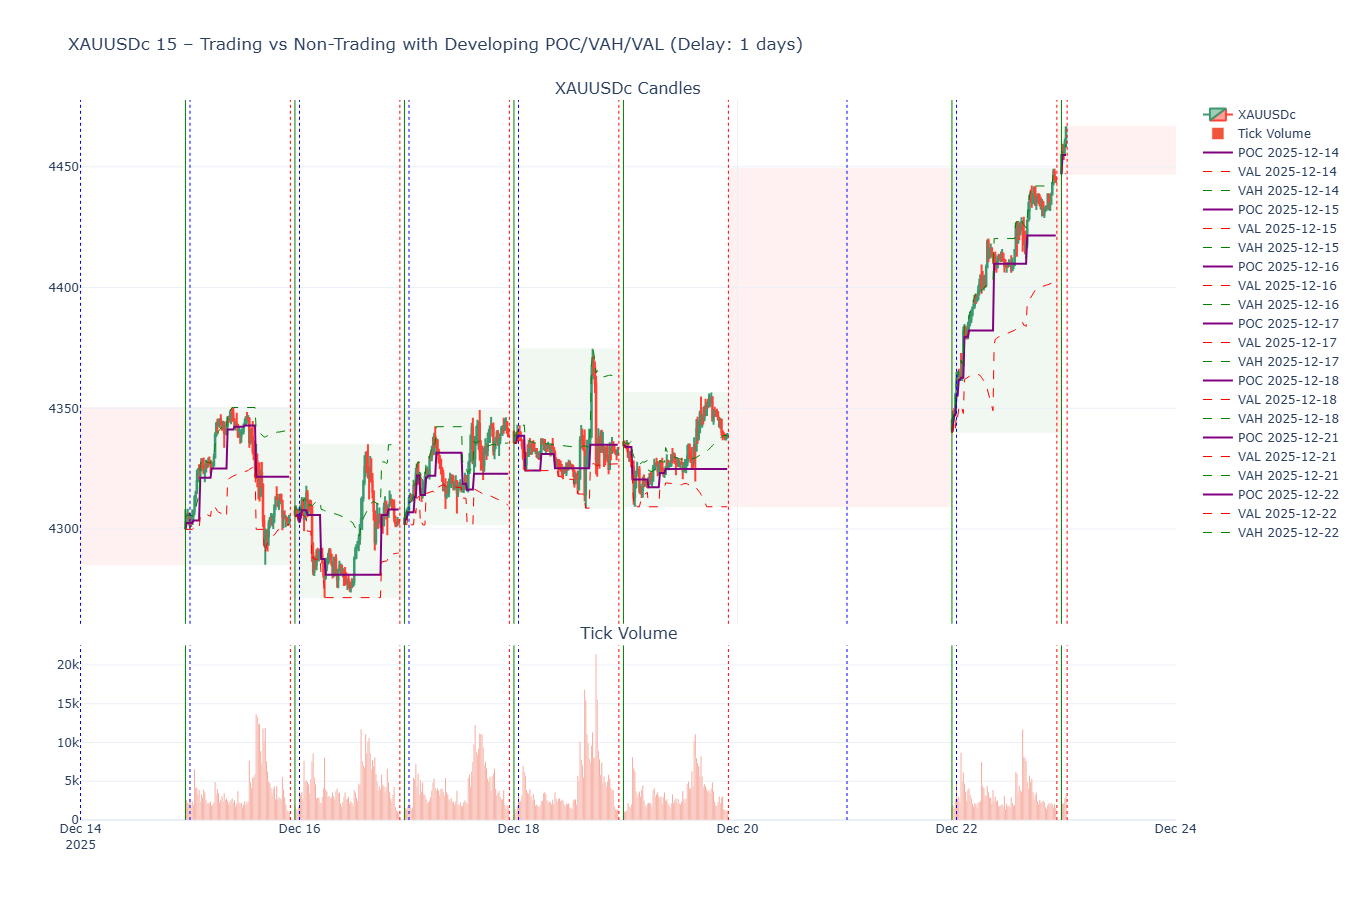

In [4]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M15  # any MT5 timeframe
lookback_days = 10             # number of days to look back
delay_days = 1                 # adjustable delay (days back from today)
utc_timezone = pytz.UTC
value_area_pct = 0.7           # 70% value area

# -------------------------------------------------
# HELPER: Convert MT5 timeframe to timedelta
# -------------------------------------------------
def timeframe_to_timedelta(tf):
    mapping = {
        mt5.TIMEFRAME_M1: timedelta(minutes=1),
        mt5.TIMEFRAME_M2: timedelta(minutes=2),
        mt5.TIMEFRAME_M3: timedelta(minutes=3),
        mt5.TIMEFRAME_M4: timedelta(minutes=4),
        mt5.TIMEFRAME_M5: timedelta(minutes=5),
        mt5.TIMEFRAME_M6: timedelta(minutes=6),
        mt5.TIMEFRAME_M10: timedelta(minutes=10),
        mt5.TIMEFRAME_M12: timedelta(minutes=12),
        mt5.TIMEFRAME_M15: timedelta(minutes=15),
        mt5.TIMEFRAME_M20: timedelta(minutes=20),
        mt5.TIMEFRAME_M30: timedelta(minutes=30),
        mt5.TIMEFRAME_H1: timedelta(hours=1),
        mt5.TIMEFRAME_H2: timedelta(hours=2),
        mt5.TIMEFRAME_H3: timedelta(hours=3),
        mt5.TIMEFRAME_H4: timedelta(hours=4),
        mt5.TIMEFRAME_H6: timedelta(hours=6),
        mt5.TIMEFRAME_H8: timedelta(hours=8),
        mt5.TIMEFRAME_H12: timedelta(hours=12),
        mt5.TIMEFRAME_D1: timedelta(days=1),
        mt5.TIMEFRAME_W1: timedelta(weeks=1),
        mt5.TIMEFRAME_MN1: timedelta(days=30),
    }
    return mapping.get(tf, timedelta(hours=1))

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA RANGE WITH DELAY
# -------------------------------------------------
utc_now = datetime.now(utc_timezone).replace(hour=0, minute=0, second=0, microsecond=0)
utc_now -= timedelta(days=delay_days)
utc_from = utc_now - timedelta(days=lookback_days)

rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)
df.sort_index(inplace=True)

# -------------------------------------------------
# DETECT TRADING SESSIONS
# -------------------------------------------------
candle_delta = timeframe_to_timedelta(timeframe)
df["gap"] = df.index.to_series().diff() > candle_delta
df["session"] = df["gap"].cumsum()

trading_sessions = []
non_trading_gaps = []

for session_id, group in df.groupby("session"):
    trading_sessions.append({
        "x0": group.index.min(),
        "x1": group.index.max() + candle_delta,
        "y0": group["low"].min(),
        "y1": group["high"].max(),
        "df": group
    })

for i in range(len(trading_sessions) - 1):
    gap_start = trading_sessions[i]["x1"]
    gap_end = trading_sessions[i + 1]["x0"]
    if gap_start < gap_end:
        non_trading_gaps.append({
            "x0": gap_start,
            "x1": gap_end,
            "y0": min(trading_sessions[i]["y0"], trading_sessions[i + 1]["y0"]),
            "y1": max(trading_sessions[i]["y1"], trading_sessions[i + 1]["y1"])
        })

first_candle = trading_sessions[0]
last_candle = trading_sessions[-1]
day_start = datetime.combine(first_candle["x0"].date(), datetime.min.time()).replace(tzinfo=utc_timezone)
day_end = datetime.combine(last_candle["x1"].date(), datetime.max.time()).replace(tzinfo=utc_timezone)

if day_start < first_candle["x0"]:
    non_trading_gaps.insert(0, {"x0": day_start, "x1": first_candle["x0"], "y0": first_candle["y0"], "y1": first_candle["y1"]})
if last_candle["x1"] < day_end:
    non_trading_gaps.append({"x0": last_candle["x1"], "x1": day_end, "y0": last_candle["y0"], "y1": last_candle["y1"]})

# -------------------------------------------------
# PLOTLY FIGURE
# -------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.75, 0.25],
    subplot_titles=(f"{symbol} Candles", "Tick Volume")
)

# Candlesticks
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name=symbol
    ),
    row=1,
    col=1
)

# Tick volume
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# Trading sessions
for session in trading_sessions:
    fig.add_shape(
        type="rect",
        x0=session["x0"],
        x1=session["x1"],
        y0=session["y0"],
        y1=session["y1"],
        line=dict(color="green", width=1),
        fillcolor="green",
        opacity=0.05,
        layer="below"
    )

# Non-trading gaps
for gap in non_trading_gaps:
    fig.add_shape(
        type="rect",
        x0=gap["x0"],
        x1=gap["x1"],
        y0=gap["y0"],
        y1=gap["y1"],
        line=dict(color="red", width=1),
        fillcolor="red",
        opacity=0.05,
        layer="below"
    )

# Vertical lines: session start, session end, 0:00 UTC
for session in trading_sessions:
    session_start = session["x0"]
    session_end = session["x1"]
    day_midnight = datetime.combine(session_start.date(), datetime.min.time()).replace(tzinfo=utc_timezone)
    fig.add_vline(x=day_midnight, line=dict(color="blue", width=1, dash="dot"), row="all", col=1)
    fig.add_vline(x=session_start, line=dict(color="green", width=1, dash="solid"), row="all", col=1)
    fig.add_vline(x=session_end, line=dict(color="red", width=1, dash="dot"), row="all", col=1)

# -------------------------------------------------
# DEVELOPING POC, VAH, VAL
# -------------------------------------------------
for session in trading_sessions:
    sess_df = session["df"]
    poc_prices = []
    vah_prices = []
    val_prices = []
    poc_times = []

    cumulative_volume = {}

    for idx, row in sess_df.iterrows():
        # Fine-grained price levels at 0.25 intervals
        price_levels = np.arange(row["low"], row["high"] + 0.01, 0.25)
        vol_per_level = row["tick_volume"] / len(price_levels)
        for price in price_levels:
            price = round(price, 2)
            cumulative_volume[price] = cumulative_volume.get(price, 0) + vol_per_level

        # Current POC
        sorted_prices = sorted(cumulative_volume.keys())
        volumes = np.array([cumulative_volume[p] for p in sorted_prices])
        poc_idx = np.argmax(volumes)
        poc_price = sorted_prices[poc_idx]
        poc_prices.append(poc_price)
        poc_times.append(idx)

        # Developing VAH and VAL
        total_vol = volumes.sum()
        target_vol = total_vol * value_area_pct
        cum_vol = volumes[poc_idx]
        lower_idx = poc_idx
        upper_idx = poc_idx

        while cum_vol < target_vol:
            if lower_idx > 0:
                lower_idx -= 1
                cum_vol += volumes[lower_idx]
            if upper_idx < len(volumes) - 1:
                upper_idx += 1
                cum_vol += volumes[upper_idx]

        val_prices.append(sorted_prices[lower_idx])
        vah_prices.append(sorted_prices[upper_idx])

    # Plot POC
    fig.add_trace(
        go.Scatter(
            x=poc_times,
            y=poc_prices,
            mode="lines",
            line=dict(color="purple", width=2),
            name=f"POC {session['x0'].date()}"
        ),
        row=1,
        col=1
    )

    # Plot VAL
    fig.add_trace(
        go.Scatter(
            x=poc_times,
            y=val_prices,
            mode="lines",
            line=dict(color="red", width=1, dash="dash"),
            name=f"VAL {session['x0'].date()}"
        ),
        row=1,
        col=1
    )

    # Plot VAH
    fig.add_trace(
        go.Scatter(
            x=poc_times,
            y=vah_prices,
            mode="lines",
            line=dict(color="green", width=1, dash="dash"),
            name=f"VAH {session['x0'].date()}"
        ),
        row=1,
        col=1
    )

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title=f"{symbol} {timeframe} – Trading vs Non-Trading with Developing POC/VAH/VAL (Delay: {delay_days} days)",
    height=900,
    xaxis_rangeslider_visible=False,
    showlegend=True,
    template="plotly_white"
)

fig.show()


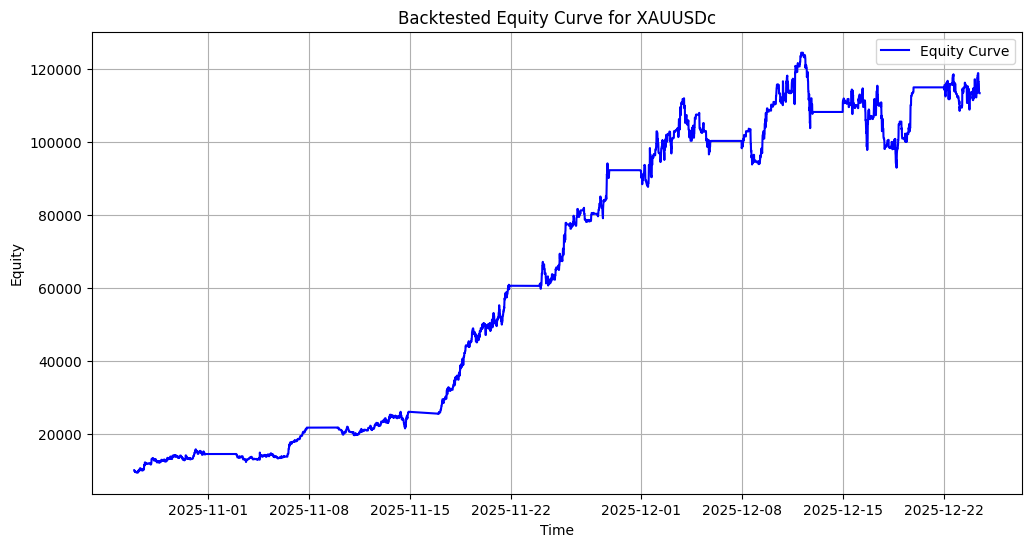

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M15
lookback_days = 60  # backtest period
utc_timezone = pytz.UTC
min_stoploss = 2.0  # minimum stop-loss distance
value_area_pct = 0.7
price_step = 0.25
initial_equity = 10000
risk_per_trade = 0.02  # 2% of equity per trade

# -------------------------------------------------
# HELPER FUNCTIONS
# -------------------------------------------------
def initialize_mt5(symbol):
    if not mt5.initialize():
        raise RuntimeError(f"MT5 init failed: {mt5.last_error()}")
    if not mt5.symbol_select(symbol, True):
        mt5.shutdown()
        raise RuntimeError(f"Symbol not available: {symbol}")

def timeframe_to_timedelta(tf):
    mapping = {
        mt5.TIMEFRAME_M1: timedelta(minutes=1),
        mt5.TIMEFRAME_M5: timedelta(minutes=5),
        mt5.TIMEFRAME_M15: timedelta(minutes=15),
        mt5.TIMEFRAME_M30: timedelta(minutes=30),
        mt5.TIMEFRAME_H1: timedelta(hours=1),
        mt5.TIMEFRAME_H4: timedelta(hours=4),
        mt5.TIMEFRAME_D1: timedelta(days=1)
    }
    return mapping.get(tf, timedelta(minutes=15))

def calculate_volume_profile_features(df, value_area_pct=0.7, price_step=0.25):
    poc_list, vah_list, val_list = [], [], []

    for idx, row in df.iterrows():
        cumulative_volume = {}
        price_levels = np.arange(row["low"], row["high"] + price_step, price_step)
        vol_per_level = row["tick_volume"] / len(price_levels)
        for price in price_levels:
            price = round(price, 2)
            cumulative_volume[price] = cumulative_volume.get(price, 0) + vol_per_level

        sorted_prices = sorted(cumulative_volume.keys())
        volumes = np.array([cumulative_volume[p] for p in sorted_prices])
        poc_idx = np.argmax(volumes)
        poc_price = sorted_prices[poc_idx]

        total_vol = volumes.sum()
        target_vol = total_vol * value_area_pct
        cum_vol = volumes[poc_idx]
        lower_idx = poc_idx
        upper_idx = poc_idx

        while cum_vol < target_vol:
            if lower_idx > 0:
                lower_idx -= 1
                cum_vol += volumes[lower_idx]
            if upper_idx < len(volumes) - 1:
                upper_idx += 1
                cum_vol += volumes[upper_idx]

        poc_list.append(poc_price)
        val_list.append(sorted_prices[lower_idx])
        vah_list.append(sorted_prices[upper_idx])

    df["POC"] = poc_list
    df["VAL"] = val_list
    df["VAH"] = vah_list
    return df

# -------------------------------------------------
# FETCH DATA
# -------------------------------------------------
initialize_mt5(symbol)
utc_now = datetime.now(utc_timezone)
utc_from = utc_now - timedelta(days=lookback_days)
rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)
df.sort_index(inplace=True)

df = calculate_volume_profile_features(df, value_area_pct=value_area_pct, price_step=price_step)

# -------------------------------------------------
# CREATE TARGET FOR ML
# -------------------------------------------------
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)
df.dropna(inplace=True)

# -------------------------------------------------
# FEATURES & MODEL
# -------------------------------------------------
feature_cols = ["open", "high", "low", "close", "tick_volume", "POC", "VAL", "VAH"]
X_values = df[feature_cols].values
y = df["target"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_values)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_scaled[:-1], y[:-1])  # train on all but last row

# -------------------------------------------------
# BACKTEST
# -------------------------------------------------
equity = initial_equity
equity_curve = [equity]

for i in range(len(df) - 1):
    row = df.iloc[i]
    features = row[feature_cols].values.reshape(1, -1)  # correct shape for scaler
    features_scaled = scaler.transform(features)
    pred = model.predict(features_scaled)[0]  # 1=buy, 0=sell

    if pred == 1:
        entry = row["close"]
        stop_loss = row["VAL"]
        take_profit = row["VAH"]
    else:
        entry = row["close"]
        stop_loss = row["VAH"]
        take_profit = row["VAL"]

    # Check stop-loss distance
    sl_distance = abs(entry - stop_loss)
    if sl_distance < min_stoploss:
        equity_curve.append(equity)
        continue

    # Risk per trade
    position_size = equity * risk_per_trade / sl_distance

    # Simulate next candle for exit
    next_row = df.iloc[i + 1]
    low_next, high_next, close_next = next_row["low"], next_row["high"], next_row["close"]

    if pred == 1:  # long
        if low_next <= stop_loss:
            pnl = -sl_distance * position_size
        elif high_next >= take_profit:
            pnl = (take_profit - entry) * position_size
        else:
            pnl = (close_next - entry) * position_size
    else:  # short
        if high_next >= stop_loss:
            pnl = -sl_distance * position_size
        elif low_next <= take_profit:
            pnl = (entry - take_profit) * position_size
        else:
            pnl = (entry - close_next) * position_size

    equity += pnl
    equity_curve.append(equity)

# -------------------------------------------------
# PLOT EQUITY CURVE
# -------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(df.index, equity_curve, label="Equity Curve", color="blue")
plt.title(f"Backtested Equity Curve for {symbol}")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M15
lookback_days = 60
utc_timezone = pytz.UTC
min_stoploss = 2.0
value_area_pct = 0.7
price_step = 0.25
initial_equity = 1000
risk_per_trade = 0.01  # 1% risk per trade

# -------------------------------------------------
# HELPER FUNCTIONS
# -------------------------------------------------
def initialize_mt5(symbol):
    if not mt5.initialize():
        raise RuntimeError(f"MT5 init failed: {mt5.last_error()}")
    if not mt5.symbol_select(symbol, True):
        mt5.shutdown()
        raise RuntimeError(f"Symbol not available: {symbol}")

def calculate_volume_profile_features(df, value_area_pct=0.7, price_step=0.25):
    poc_list, vah_list, val_list = [], [], []
    for idx, row in df.iterrows():
        cumulative_volume = {}
        price_levels = np.arange(row["low"], row["high"] + price_step, price_step)
        vol_per_level = row["tick_volume"] / len(price_levels)
        for price in price_levels:
            price = round(price, 2)
            cumulative_volume[price] = cumulative_volume.get(price, 0) + vol_per_level

        sorted_prices = sorted(cumulative_volume.keys())
        volumes = np.array([cumulative_volume[p] for p in sorted_prices])
        poc_idx = np.argmax(volumes)
        poc_price = sorted_prices[poc_idx]

        total_vol = volumes.sum()
        target_vol = total_vol * value_area_pct
        cum_vol = volumes[poc_idx]
        lower_idx, upper_idx = poc_idx, poc_idx

        while cum_vol < target_vol:
            if lower_idx > 0:
                lower_idx -= 1
                cum_vol += volumes[lower_idx]
            if upper_idx < len(volumes) - 1:
                upper_idx += 1
                cum_vol += volumes[upper_idx]

        poc_list.append(poc_price)
        val_list.append(sorted_prices[lower_idx])
        vah_list.append(sorted_prices[upper_idx])

    df["POC"] = poc_list
    df["VAL"] = val_list
    df["VAH"] = vah_list
    return df

# -------------------------------------------------
# FETCH DATA
# -------------------------------------------------
initialize_mt5(symbol)
utc_now = datetime.now(utc_timezone)
utc_from = utc_now - timedelta(days=lookback_days)
rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)
df.sort_index(inplace=True)

df = calculate_volume_profile_features(df, value_area_pct=value_area_pct, price_step=price_step)

# -------------------------------------------------
# CREATE TARGET FOR ML
# -------------------------------------------------
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)
df.dropna(inplace=True)

# -------------------------------------------------
# FEATURES & MODEL
# -------------------------------------------------
feature_cols = ["open", "high", "low", "close", "tick_volume", "POC", "VAL", "VAH"]
X_values = df[feature_cols].values
y = df["target"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_values)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_scaled[:-1], y[:-1])

# -------------------------------------------------
# BACKTEST
# -------------------------------------------------
equity = initial_equity
equity_curve = [equity]
trade_history = []  # store executed trades

for i in range(len(df) - 1):
    row = df.iloc[i]
    features = row[feature_cols].values.reshape(1, -1)
    features_scaled = scaler.transform(features)
    pred = model.predict(features_scaled)[0]

    if pred == 1:
        entry = row["close"]
        stop_loss = row["VAL"]
        take_profit = row["VAH"]
    else:
        entry = row["close"]
        stop_loss = row["VAH"]
        take_profit = row["VAL"]

    sl_distance = abs(entry - stop_loss)
    if sl_distance < min_stoploss:
        equity_curve.append(equity)
        continue

    position_size = equity * risk_per_trade / sl_distance
    next_row = df.iloc[i + 1]
    low_next, high_next, close_next = next_row["low"], next_row["high"], next_row["close"]

    if pred == 1:
        if low_next <= stop_loss:
            pnl = -sl_distance * position_size
            exit_price = stop_loss
        elif high_next >= take_profit:
            pnl = (take_profit - entry) * position_size
            exit_price = take_profit
        else:
            pnl = (close_next - entry) * position_size
            exit_price = close_next
    else:
        if high_next >= stop_loss:
            pnl = -sl_distance * position_size
            exit_price = stop_loss
        elif low_next <= take_profit:
            pnl = (entry - take_profit) * position_size
            exit_price = take_profit
        else:
            pnl = (entry - close_next) * position_size
            exit_price = close_next

    equity += pnl
    equity_curve.append(equity)

    # store trade info for plotting
    trade_history.append({
        "time": row.name,
        "entry": entry,
        "stop_loss": stop_loss,
        "take_profit": take_profit,
        "direction": "BUY" if pred==1 else "SELL",
        "exit": exit_price
    })

# -------------------------------------------------
# PLOT CANDLESTICK + TRADE HISTORY
# -------------------------------------------------
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    row_heights=[0.7, 0.3], vertical_spacing=0.05,
                    subplot_titles=(f"{symbol} Candlestick & Trades", "Equity Curve"))

# Candlestick
fig.add_trace(go.Candlestick(
    x=df.index, open=df["open"], high=df["high"], low=df["low"], close=df["close"], name="Price"
), row=1, col=1)

# Plot executed trades
for trade in trade_history:
    color = "green" if trade["direction"]=="BUY" else "red"
    # entry
    fig.add_shape(type="line",
                  x0=trade["time"], x1=trade["time"],
                  y0=trade["entry"], y1=trade["exit"],
                  line=dict(color=color, width=2),
                  row=1, col=1)
    # stop-loss line
    fig.add_shape(type="line",
                  x0=trade["time"], x1=trade["time"] + timedelta(minutes=1),
                  y0=trade["stop_loss"], y1=trade["stop_loss"],
                  line=dict(color="black", width=1, dash="dash"),
                  row=1, col=1)
    # take-profit line
    fig.add_shape(type="line",
                  x0=trade["time"], x1=trade["time"] + timedelta(minutes=1),
                  y0=trade["take_profit"], y1=trade["take_profit"],
                  line=dict(color="blue", width=1, dash="dash"),
                  row=1, col=1)

# Equity curve
fig.add_trace(go.Scatter(
    x=df.index, y=equity_curve, mode="lines", name="Equity Curve", line=dict(color="orange")
), row=2, col=1)

fig.update_layout(height=900, xaxis_rangeslider_visible=False)
fig.show()
qwe



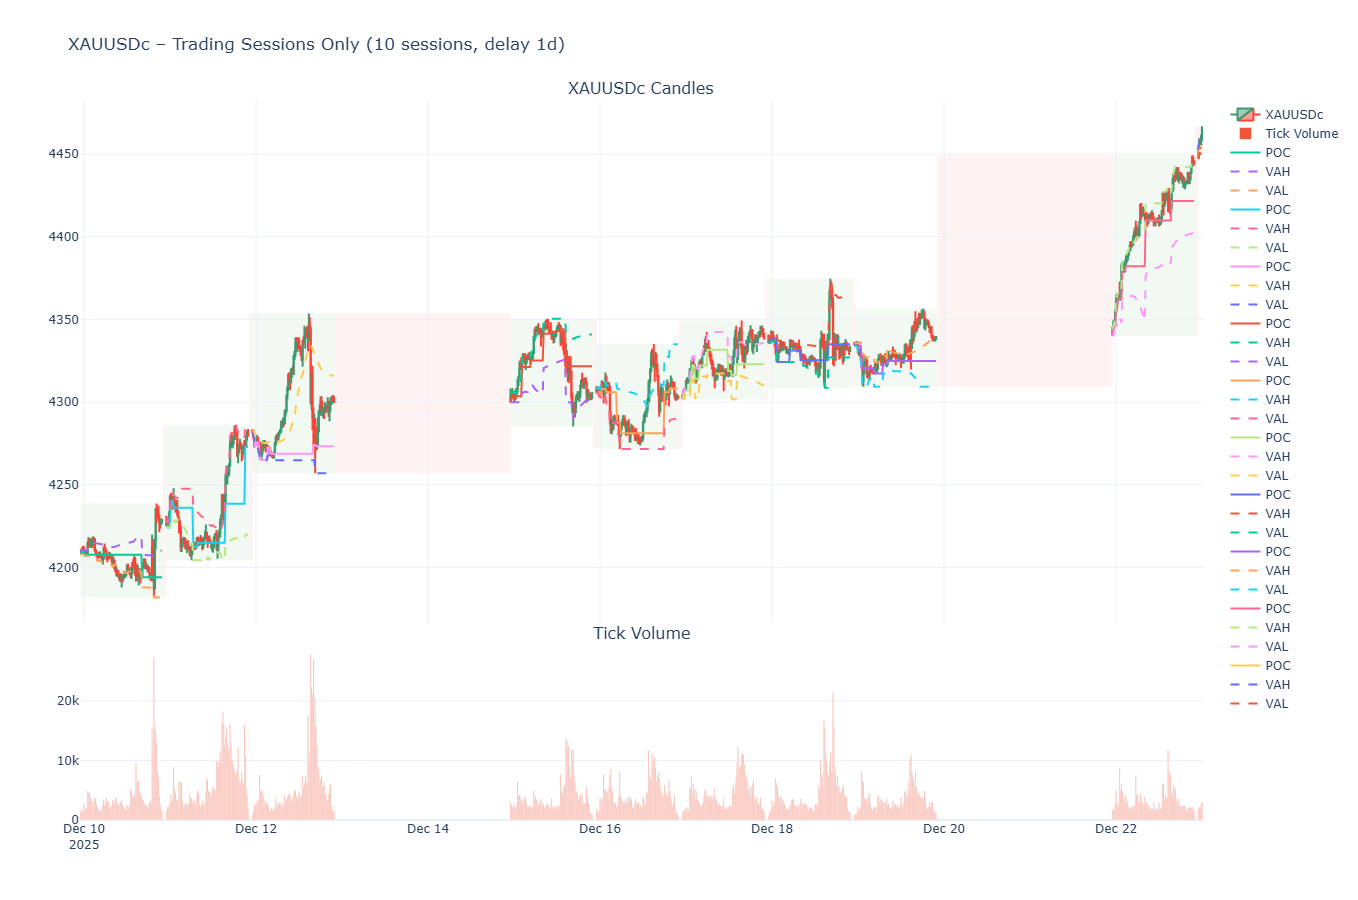

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M15
lookback_days = 10             # NUMBER OF TRADING SESSIONS
delay_days = 1
utc_timezone = pytz.UTC
value_area_pct = 0.7

# -------------------------------------------------
# HELPER: Convert MT5 timeframe to timedelta
# -------------------------------------------------
def timeframe_to_timedelta(tf):
    mapping = {
        mt5.TIMEFRAME_M1: timedelta(minutes=1),
        mt5.TIMEFRAME_M2: timedelta(minutes=2),
        mt5.TIMEFRAME_M3: timedelta(minutes=3),
        mt5.TIMEFRAME_M4: timedelta(minutes=4),
        mt5.TIMEFRAME_M5: timedelta(minutes=5),
        mt5.TIMEFRAME_M6: timedelta(minutes=6),
        mt5.TIMEFRAME_M10: timedelta(minutes=10),
        mt5.TIMEFRAME_M12: timedelta(minutes=12),
        mt5.TIMEFRAME_M15: timedelta(minutes=15),
        mt5.TIMEFRAME_M20: timedelta(minutes=20),
        mt5.TIMEFRAME_M30: timedelta(minutes=30),
        mt5.TIMEFRAME_H1: timedelta(hours=1),
        mt5.TIMEFRAME_H2: timedelta(hours=2),
        mt5.TIMEFRAME_H3: timedelta(hours=3),
        mt5.TIMEFRAME_H4: timedelta(hours=4),
        mt5.TIMEFRAME_H6: timedelta(hours=6),
        mt5.TIMEFRAME_H8: timedelta(hours=8),
        mt5.TIMEFRAME_H12: timedelta(hours=12),
        mt5.TIMEFRAME_D1: timedelta(days=1),
        mt5.TIMEFRAME_W1: timedelta(weeks=1),
        mt5.TIMEFRAME_MN1: timedelta(days=30),
    }
    return mapping.get(tf, timedelta(hours=1))

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(mt5.last_error())

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA (TRADING-DAY AWARE)
# -------------------------------------------------
utc_end = datetime.now(utc_timezone).replace(
    hour=0, minute=0, second=0, microsecond=0
) - timedelta(days=delay_days)

raw_from = utc_end - timedelta(days=lookback_days * 3)

rates = mt5.copy_rates_range(symbol, timeframe, raw_from, utc_end)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)
df.sort_index(inplace=True)

# -------------------------------------------------
# DETECT TRADING SESSIONS
# -------------------------------------------------
candle_delta = timeframe_to_timedelta(timeframe)
df["gap"] = df.index.to_series().diff() > candle_delta
df["session"] = df["gap"].cumsum()

# KEEP ONLY LAST N TRADING SESSIONS
last_sessions = df["session"].unique()[-lookback_days:]
df = df[df["session"].isin(last_sessions)]

# -------------------------------------------------
# BUILD SESSION + GAP STRUCTURES
# -------------------------------------------------
trading_sessions = []
non_trading_gaps = []

for _, group in df.groupby("session"):
    trading_sessions.append({
        "x0": group.index.min(),
        "x1": group.index.max() + candle_delta,
        "y0": group["low"].min(),
        "y1": group["high"].max(),
        "df": group
    })

for i in range(len(trading_sessions) - 1):
    gap_start = trading_sessions[i]["x1"]
    gap_end = trading_sessions[i + 1]["x0"]
    if gap_start < gap_end:
        non_trading_gaps.append({
            "x0": gap_start,
            "x1": gap_end,
            "y0": min(trading_sessions[i]["y0"], trading_sessions[i + 1]["y0"]),
            "y1": max(trading_sessions[i]["y1"], trading_sessions[i + 1]["y1"])
        })

# -------------------------------------------------
# PLOTLY FIGURE
# -------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.75, 0.25],
    subplot_titles=(f"{symbol} Candles", "Tick Volume")
)

fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name=symbol
    ),
    row=1,
    col=1
)

fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# -------------------------------------------------
# SESSION VISUALS
# -------------------------------------------------
for session in trading_sessions:
    fig.add_shape(
        type="rect",
        x0=session["x0"],
        x1=session["x1"],
        y0=session["y0"],
        y1=session["y1"],
        fillcolor="green",
        opacity=0.05,
        line=dict(width=0),
        layer="below"
    )

for gap in non_trading_gaps:
    fig.add_shape(
        type="rect",
        x0=gap["x0"],
        x1=gap["x1"],
        y0=gap["y0"],
        y1=gap["y1"],
        fillcolor="red",
        opacity=0.05,
        line=dict(width=0),
        layer="below"
    )

# -------------------------------------------------
# DEVELOPING POC / VAH / VAL
# -------------------------------------------------
for session in trading_sessions:
    sess_df = session["df"]
    cumulative_volume = {}

    poc_prices, vah_prices, val_prices, times = [], [], [], []

    for t, row in sess_df.iterrows():
        prices = np.arange(row["low"], row["high"] + 0.01, 0.25)
        vol = row["tick_volume"] / max(len(prices), 1)

        for p in prices:
            p = round(p, 2)
            cumulative_volume[p] = cumulative_volume.get(p, 0) + vol

        levels = np.array(sorted(cumulative_volume))
        vols = np.array([cumulative_volume[p] for p in levels])

        poc_idx = np.argmax(vols)
        poc_price = levels[poc_idx]

        target = vols.sum() * value_area_pct
        cum = vols[poc_idx]
        lo = hi = poc_idx

        while cum < target:
            if lo > 0:
                lo -= 1
                cum += vols[lo]
            if hi < len(vols) - 1:
                hi += 1
                cum += vols[hi]

        poc_prices.append(poc_price)
        vah_prices.append(levels[hi])
        val_prices.append(levels[lo])
        times.append(t)

    fig.add_trace(go.Scatter(x=times, y=poc_prices, mode="lines", line=dict(width=2), name="POC"), row=1, col=1)
    fig.add_trace(go.Scatter(x=times, y=vah_prices, mode="lines", line=dict(dash="dash"), name="VAH"), row=1, col=1)
    fig.add_trace(go.Scatter(x=times, y=val_prices, mode="lines", line=dict(dash="dash"), name="VAL"), row=1, col=1)

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title=f"{symbol} – Trading Sessions Only ({lookback_days} sessions, delay {delay_days}d)",
    height=900,
    xaxis_rangeslider_visible=False,
    template="plotly_white"
)

fig.show()


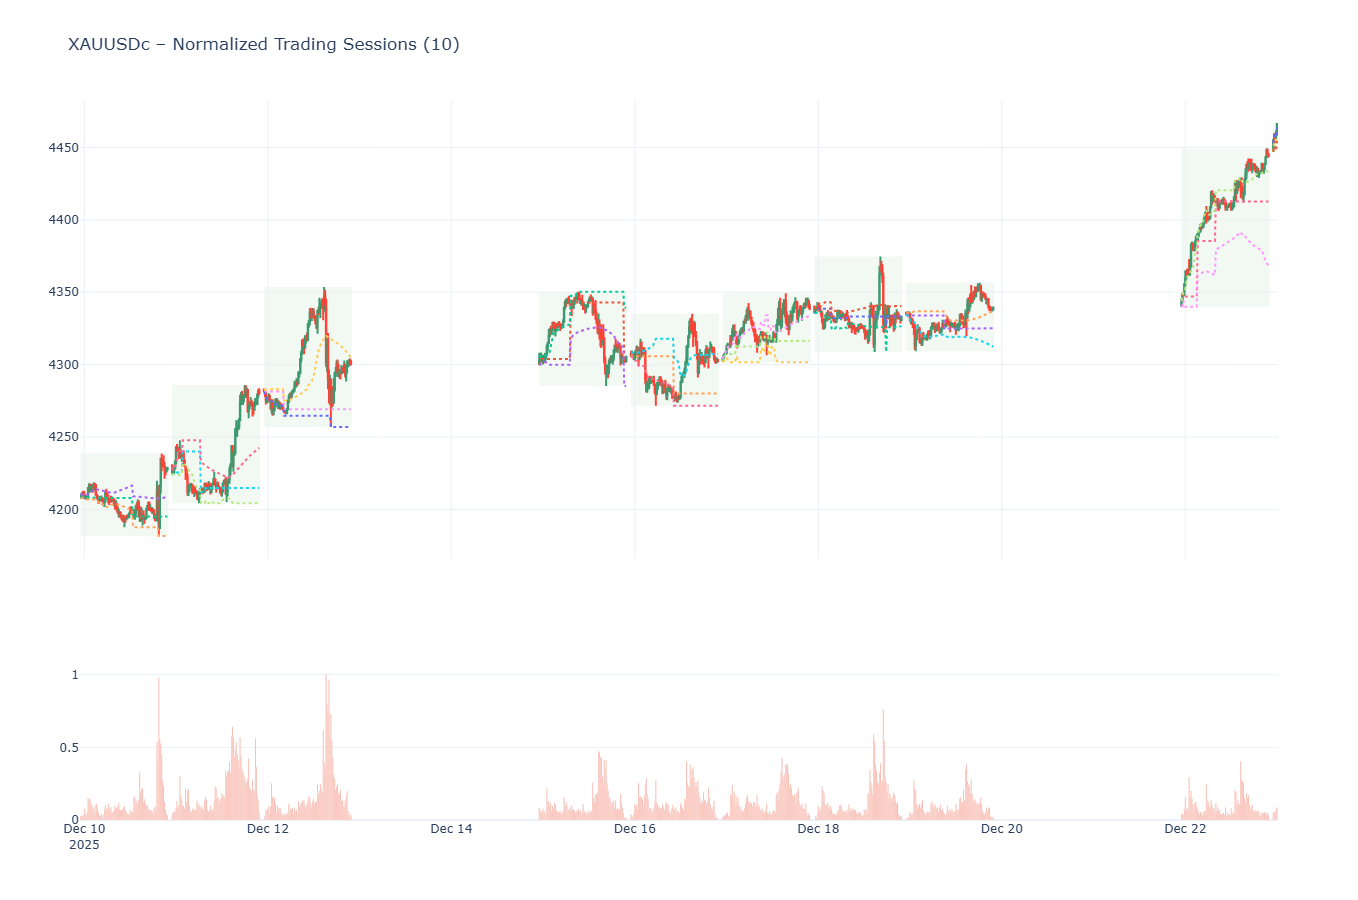

In [6]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M15
lookback_days = 10
delay_days = 1
utc_timezone = pytz.UTC
value_area_pct = 0.7

# -------------------------------------------------
# TIMEFRAME → DELTA
# -------------------------------------------------
def timeframe_to_timedelta(tf):
    return {
        mt5.TIMEFRAME_M15: timedelta(minutes=15),
        mt5.TIMEFRAME_M30: timedelta(minutes=30),
        mt5.TIMEFRAME_H1: timedelta(hours=1),
    }.get(tf, timedelta(minutes=15))

# -------------------------------------------------
# MT5 INIT
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(mt5.last_error())

mt5.symbol_select(symbol, True)

# -------------------------------------------------
# FETCH DATA (TRADING-SESSIONS AWARE)
# -------------------------------------------------
utc_end = datetime.now(utc_timezone).replace(
    hour=0, minute=0, second=0, microsecond=0
) - timedelta(days=delay_days)

raw_from = utc_end - timedelta(days=lookback_days * 3)

rates = mt5.copy_rates_range(symbol, timeframe, raw_from, utc_end)
mt5.shutdown()

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)
df.sort_index(inplace=True)

# -------------------------------------------------
# SESSION DETECTION
# -------------------------------------------------
candle_delta = timeframe_to_timedelta(timeframe)
df["gap"] = df.index.to_series().diff() > candle_delta
df["session"] = df["gap"].cumsum()

last_sessions = df["session"].unique()[-lookback_days:]
df = df[df["session"].isin(last_sessions)]

# -------------------------------------------------
# NORMALIZE TICK VOLUME
# -------------------------------------------------
tv_min = df["tick_volume"].min()
tv_max = df["tick_volume"].max()
df["tick_volume_norm"] = (df["tick_volume"] - tv_min) / max(tv_max - tv_min, 1)

# -------------------------------------------------
# BUILD SESSION STRUCTURES
# -------------------------------------------------
trading_sessions = []

for _, g in df.groupby("session"):
    trading_sessions.append({
        "x0": g.index.min(),
        "x1": g.index.max() + candle_delta,
        "y0": g["low"].min(),
        "y1": g["high"].max(),
        "df": g
    })

# -------------------------------------------------
# FIGURE
# -------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    row_heights=[0.75, 0.25]
)

fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"]
    ),
    row=1,
    col=1
)

fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume_norm"]
    ),
    row=2,
    col=1
)

# -------------------------------------------------
# SESSION SHADING
# -------------------------------------------------
for s in trading_sessions:
    fig.add_shape(
        type="rect",
        x0=s["x0"],
        x1=s["x1"],
        y0=s["y0"],
        y1=s["y1"],
        fillcolor="green",
        opacity=0.05,
        line=dict(width=0),
        layer="below"
    )

# -------------------------------------------------
# DEVELOPING POC / VAH / VAL (NORMALIZED VOLUME)
# -------------------------------------------------
for s in trading_sessions:
    sess = s["df"]
    cum_vol = {}
    poc, vah, val, tms = [], [], [], []

    for t, r in sess.iterrows():
        levels = np.arange(r["low"], r["high"] + 0.01, 0.1)
        vol = 1.0 / max(len(levels), 1)

        for p in levels:
            p = round(p, 2)
            cum_vol[p] = cum_vol.get(p, 0) + vol

        prices = np.array(sorted(cum_vol))
        vols = np.array([cum_vol[p] for p in prices])
        vols /= vols.sum()

        poc_idx = np.argmax(vols)
        target = value_area_pct

        lo = hi = poc_idx
        acc = vols[poc_idx]

        while acc < target:
            if lo > 0:
                lo -= 1
                acc += vols[lo]
            if hi < len(vols) - 1:
                hi += 1
                acc += vols[hi]

        poc.append(prices[poc_idx])
        vah.append(prices[hi])
        val.append(prices[lo])
        tms.append(t)

    fig.add_trace(go.Scatter(x=tms, y=poc, mode="lines", line=dict(dash="dot")), row=1, col=1)
    fig.add_trace(go.Scatter(x=tms, y=vah, mode="lines", line=dict(dash="dot")), row=1, col=1)
    fig.add_trace(go.Scatter(x=tms, y=val, mode="lines", line=dict(dash="dot")), row=1, col=1)

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title=f"{symbol} – Normalized Trading Sessions ({lookback_days})",
    height=900,
    showlegend=False,
    xaxis_rangeslider_visible=False,
    template="plotly_white"
)

fig.show()


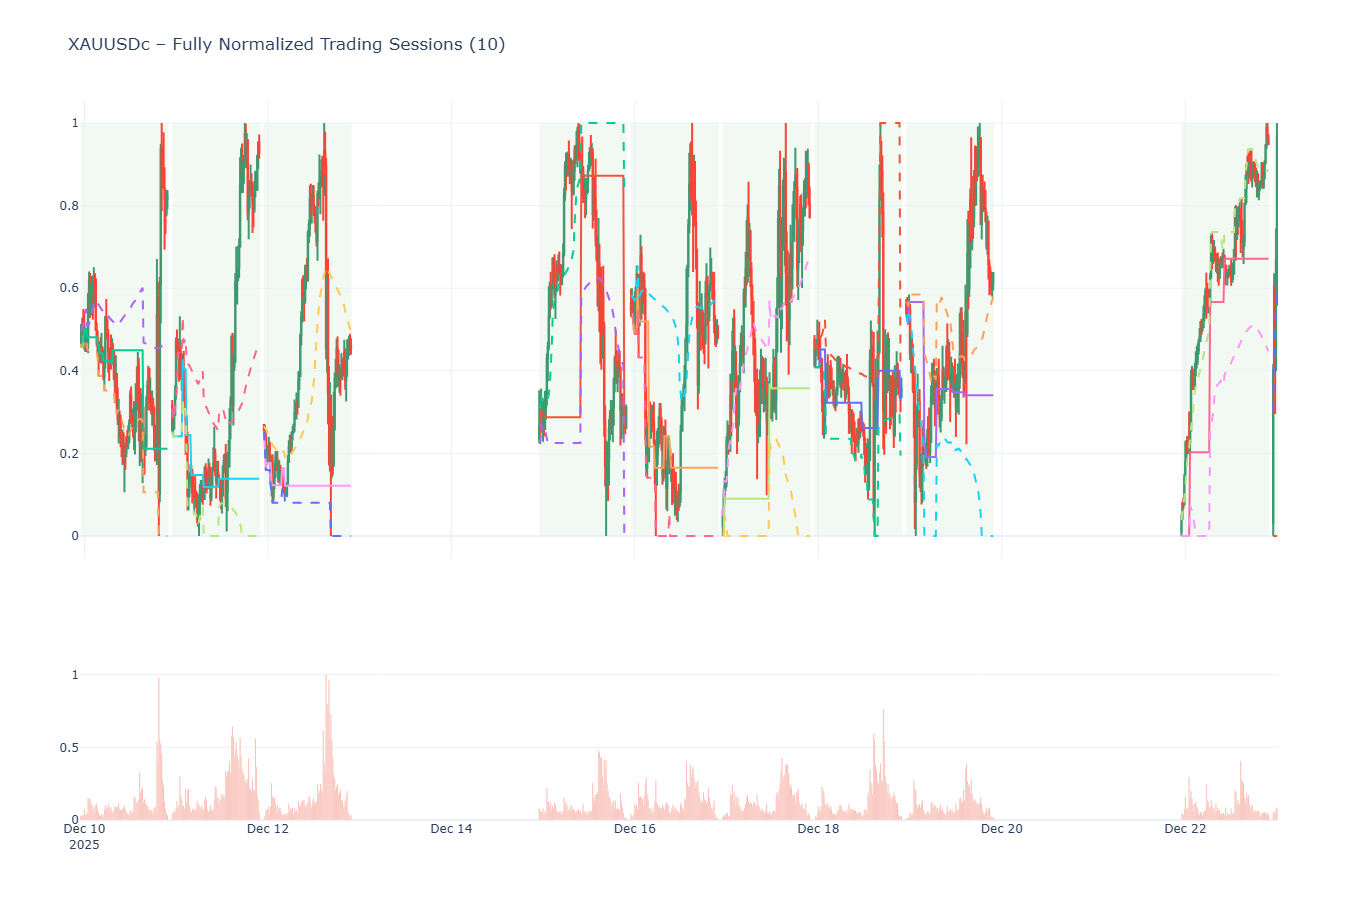

In [2]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M15
lookback_days = 10
delay_days = 1
utc_timezone = pytz.UTC
value_area_pct = 0.7

# -------------------------------------------------
# TIMEFRAME → DELTA
# -------------------------------------------------
def timeframe_to_timedelta(tf):
    return {
        mt5.TIMEFRAME_M15: timedelta(minutes=15),
        mt5.TIMEFRAME_M30: timedelta(minutes=30),
        mt5.TIMEFRAME_H1: timedelta(hours=1),
    }.get(tf, timedelta(minutes=15))

# -------------------------------------------------
# MT5 INIT
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(mt5.last_error())

mt5.symbol_select(symbol, True)

# -------------------------------------------------
# FETCH DATA (TRADING-SESSIONS AWARE)
# -------------------------------------------------
utc_end = datetime.now(utc_timezone).replace(
    hour=0, minute=0, second=0, microsecond=0
) - timedelta(days=delay_days)

raw_from = utc_end - timedelta(days=lookback_days * 3)

rates = mt5.copy_rates_range(symbol, timeframe, raw_from, utc_end)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)
df.sort_index(inplace=True)

# -------------------------------------------------
# SESSION DETECTION
# -------------------------------------------------
candle_delta = timeframe_to_timedelta(timeframe)
df["gap"] = df.index.to_series().diff() > candle_delta
df["session"] = df["gap"].cumsum()

last_sessions = df["session"].unique()[-lookback_days:]
df = df[df["session"].isin(last_sessions)]

# -------------------------------------------------
# NORMALIZE TICK VOLUME (GLOBAL)
# -------------------------------------------------
tv_min = df["tick_volume"].min()
tv_max = df["tick_volume"].max()
df["tick_volume_norm"] = (df["tick_volume"] - tv_min) / max(tv_max - tv_min, 1)

# -------------------------------------------------
# NORMALIZE OHLC PER SESSION
# -------------------------------------------------
df_norm = []

for _, g in df.groupby("session"):
    p_min = g[["open", "high", "low", "close"]].min().min()
    p_max = g[["open", "high", "low", "close"]].max().max()
    scale = max(p_max - p_min, 1e-6)

    g = g.copy()
    for col in ["open", "high", "low", "close"]:
        g[col + "_norm"] = (g[col] - p_min) / scale

    g["low_norm"] = np.minimum.reduce([
        g["open_norm"], g["high_norm"], g["low_norm"], g["close_norm"]
    ])
    g["high_norm"] = np.maximum.reduce([
        g["open_norm"], g["high_norm"], g["low_norm"], g["close_norm"]
    ])

    df_norm.append(g)

df = pd.concat(df_norm).sort_index()

# -------------------------------------------------
# BUILD SESSION STRUCTURES
# -------------------------------------------------
trading_sessions = []

for _, g in df.groupby("session"):
    trading_sessions.append({
        "x0": g.index.min(),
        "x1": g.index.max() + candle_delta,
        "y0": g["low_norm"].min(),
        "y1": g["high_norm"].max(),
        "df": g
    })

# -------------------------------------------------
# FIGURE
# -------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    row_heights=[0.75, 0.25]
)

# Normalized Candlesticks
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open_norm"],
        high=df["high_norm"],
        low=df["low_norm"],
        close=df["close_norm"]
    ),
    row=1,
    col=1
)

# Normalized Volume
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume_norm"]
    ),
    row=2,
    col=1
)

# -------------------------------------------------
# SESSION SHADING
# -------------------------------------------------
for s in trading_sessions:
    fig.add_shape(
        type="rect",
        x0=s["x0"],
        x1=s["x1"],
        y0=s["y0"],
        y1=s["y1"],
        fillcolor="green",
        opacity=0.05,
        line=dict(width=0),
        layer="below"
    )

# -------------------------------------------------
# DEVELOPING POC / VAH / VAL (NORMALIZED)
# -------------------------------------------------
for s in trading_sessions:
    sess = s["df"]
    cum_vol = {}
    poc, vah, val, tms = [], [], [], []

    for t, r in sess.iterrows():
        levels = np.linspace(r["low_norm"], r["high_norm"], 12)
        vol = 1.0 / max(len(levels), 1)

        for p in levels:
            p = round(float(p), 4)
            cum_vol[p] = cum_vol.get(p, 0) + vol

        prices = np.array(sorted(cum_vol))
        vols = np.array([cum_vol[p] for p in prices])
        vols /= vols.sum()

        poc_idx = np.argmax(vols)
        lo = hi = poc_idx
        acc = vols[poc_idx]

        while acc < value_area_pct:
            if lo > 0:
                lo -= 1
                acc += vols[lo]
            if hi < len(vols) - 1:
                hi += 1
                acc += vols[hi]

        poc.append(prices[poc_idx])
        vah.append(prices[hi])
        val.append(prices[lo])
        tms.append(t)

    fig.add_trace(go.Scatter(x=tms, y=poc, mode="lines"), row=1, col=1)
    fig.add_trace(go.Scatter(x=tms, y=vah, mode="lines", line=dict(dash="dash")), row=1, col=1)
    fig.add_trace(go.Scatter(x=tms, y=val, mode="lines", line=dict(dash="dash")), row=1, col=1)

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title=f"{symbol} – Fully Normalized Trading Sessions ({lookback_days})",
    height=900,
    showlegend=False,
    xaxis_rangeslider_visible=False,
    template="plotly_white"
)

fig.show()
